# Using `pyoscode` in cosmology

`pyoscode` is a fast numerical routine suitable for equations of the form 

$$ \ddot{x} + 2\gamma(t)\dot{x} + \omega^2(t) = 0, $$
with

- $x(t)$: a scalar variable (e.g. curvature perturbation),
- $\omega(t)$: frequency,
- $\gamma(t)$: friction or first-derivative term.

In general $\gamma$, $\omega$ may not be explicit functions of time, and `pyoscode` can deal with them given as

- _in Python_: `numpy.array`s
- _in C++_: `array`s, `list`s, `std::vector`s, `Eigen::Vector`s, or functions.

Below we'll look at examples using the _Python_ interface, but first, let's look at the short summary of the relevant cosmology.

## Cosmology

We wish to calculate the primordial power spectrum of scalar perturbations in a universe with some spatial curvature. This involves 
1. computing the isotropic, expanding "background" evolution,
2. then solving the equation of motion of the perturbations of varying lengthscales.

### Background evolution

The relevant equations are the Friedmann equations and the continuity equation. They can be cast into the following form:

$$ \frac{d\ln{\Omega_k}}{dN} = 4 + \Omega_k\big(4K - 2a^2V(\phi)\big), $$

$$ \Big(\frac{d\phi}{dN}\Big)^2 = 6 + \Omega_k\big(6K - 2a^2V(\phi)\big). $$

with 

- $a$: scale factor of the universe
- $H$: Hubble parameter
- $N = \ln{a}$: number of e-folds, **the independent variable**
- $ \Omega_k = \frac{1}{(aH)^2}$, curvature density
- $K$: spatial curvature, $0, \pm1$ for flat, closed, and open universes
- $\phi$: inflaton field
- $ V$: inflationary potential

### Evolution of the perturbations

The equation of motion of the perturbations is given by the Mukhanov--Sasaki equation. It takes the form of a generalised oscillator, with frequency and damping terms given by (when written in terms of $N$):

$$ \omega^2 = \Omega_k\Bigg( (k_2 - K) - \frac{2Kk_2}{EK +k_2}\frac{\dot{E}}{E}\Bigg), $$
$$ 2\gamma = K\Omega_k + 3 - E + \frac{k_2}{EK + k_2}\frac{\dot{E}}{E}, $$

with 

- $E = \frac{1}{2}\dot{\phi}^2$ (overdot is differentiation wrt $N$)
- $k_2 = k(k+2) - 3K$ if $K > 0$, and $k_2 = k^2 - 3K$ otherwise.

# Code

## A flat universe

In [1]:
import pyoscode
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp

cosmological parameters:

- $m$: inflaton mass
- $mp$: Planck mass
- $nv$: exponent in inflationary potential
- $K$: curvature, $\pm1$, 0

In [2]:
m = 1
mp = 1
nv = 2 
K = 0

Define the inflationary potential, its derivative, and the background equations. Also define initial conditions for the perturbations such that they start from the _Bunch-Davies_ vacuum.

In [3]:
def V(phi):
    """ inflationary potential"""
    return 0.5*m**2*phi**nv

def dV(phi):
    """ derivative of the inflationary potential """
    return 0.5*nv*m**2*phi**(nv-1)

def bgeqs(t, y):
    """ System of equations describing the evolution of the cosmological
    background """
    dy = np.zeros(y.shape)
    dy[0] = 4.0 + np.exp(y[0])*(4.0*K - 2.0*np.exp(2.0*t)*V(y[1]))
    dy[1] = - np.sqrt(6.0 + np.exp(y[0])*(6.0*K -
    2.0*np.exp(2.0*t)*V(y[1])))
    return dy

def endinfl(t, y):
    """ Crosses zero when inflation ends """
    dphi = bgeqs(t,y)[1]
    epsilon = 0.5*dphi**2
    return epsilon - 1.

def bdic(k, phi, dphi, ddphi, N):
    """ Defines the Bunch-Davies vacuum solution
    for a given perturbation mode """
    a0 = np.exp(N)
    dz_z = ddphi/dphi + 1.
    z = a0*dphi
    R = 1./(np.sqrt(2.*k)*z) + 1j*0
    dR = - R*dz_z - np.sqrt(k/2.*ok_i)/z*1j
    return R,dR

def pps(k, rk1, rk2, x01, dx01, x02, dx02, x0, dx0):
    """ Enforces x,dx as initial conditions by linear
    combination of two solutions rk1 and rk2, which had
    initial conditions x01, dx01 and x02, dx02 """
    a = (x0*dx02 - dx0*x02)/(x01*dx02 - dx01*x02)
    b = (x0*dx01 - dx0*x01)/(x02*dx01 - dx02*x01)
    power = np.abs(a*rk1 + b*rk2)**2*k**3/(2*np.pi**2)
    return power

Now solve the background with the help of `scipy.integrate`

In [36]:
# \Omega_k and N at the start of inflation fully
# parametrise the background.
ok_i = 2.1e-3
N_i = 1.
# Nominal end point of integration (we'll stop at the end of inflation)
N_f = 80.
# Points at which we'll obtain the background solution
Nbg = 10000 # This determines grid fineness, see note below.
N = np.linspace(N_i,N_f,Nbg)
# Initial conditions
phi_i = np.sqrt(4.*(1./ok_i + K)*np.exp(-2.0*N_i)/m**2)
logok_i = np.log(ok_i)
y_i = np.array([logok_i, phi_i])
# Solve for the background until the end of inflation
endinfl.terminal = True
endinfl.direction = 1
bgsol = solve_ivp(bgeqs, (N_i,N_f), y_i, events=endinfl, t_eval=N, rtol=1e-8, atol=1e-10)

**Note:** the most important parameter from a numerical perspective is $N_{\mathrm{bg}}$. This determines the fineness of the grid on which $\omega$ and $\gamma$ are defined. The speed of the method depends on how precisely numerical derivatives and integrals of $\omega$, $\gamma$ can be computed. If you experience slow-down, it is very likely that this grid was not fine enough. 

The number of e-folds of inflation we got from this setup is

In [5]:
bgsol.t_events[0][0]-N_i

61.096795417950304

We're now ready to define the equation of motion of the perturbations. `pyoscode` takes the frequency and the damping term of the oscillator as `numpy.array`s.

In [6]:
logok = bgsol.y[0]
phi = bgsol.y[1]
N = bgsol.t
dphi = np.array([-np.sqrt(6.0 + np.exp(Logok)*(6.0*K -
    2.0*np.exp(2.0*t)*V(Phi))) for Logok,Phi,t in zip(logok,phi,N) ])
dlogok = np.array([4.0 + np.exp(Logok)*(4.0*K - 2.0*np.exp(2.0*t)*V(Phi)) for Logok,Phi,t in zip(logok,phi,N) ])
dE_E = dlogok - 4. -2.*dV(phi)*np.exp(logok)*np.exp(2.*N)/dphi
E = 0.5*dphi**2
# Damping term
g = 0.5*(3 - E + dE_E)
# frequency
logw = 0.5*logok

Now we wish solve the Mukhanov--Sasaki equation in a loop, iterating over increasing values of $k$. We need to determine the range of integration for each: we'll start at a fixed $N$, and integrate until the mode is "well outside the Hubble horizon", $k < (aH)/100$.

In [7]:
# range of wavevectors
ks = np.logspace(0,4,1000)
end = np.zeros_like(ks,dtype=int)
endindex = 0
for i in range(len(ks)):
    for j in range(endindex,Nbg):
        if np.exp(-0.5*logok[j])/ks[i] > 100:
            end[i] = j
            endindex = j
            break

We're now ready to solve the Mukhanov-Sasaki equation in a loop and generate a primordial power spectrum.

In [10]:
spectrum = np.zeros_like(ks,dtype=complex)
for i,k in enumerate(ks):
    # Bunch-Davies i.c.
    phi_0 = phi[0]
    dphi_0 = dphi[0]
    ddphi_0 = 0.5*dE_E[0]*dphi_0
    N_0 = N_i
    x0, dx0 = bdic(k, phi_0, dphi_0, ddphi_0, N_0)
    x01 = 1.0
    dx01 = 0.0
    x02 = 0.0
    dx02 = 1.0
    # Linearly indep. solutions
    sol1 = pyoscode.solve(N,logw+np.log(k),g,N_i,N[end[i]],x01,dx01,logw=True)
    sol2 = pyoscode.solve(N,logw+np.log(k),g,N_i,N[end[i]],x02,dx02,logw=True)
    rk1 = sol1["sol"][-1]
    rk2 = sol2["sol"][-1]
    spectrum[i] = pps(k, rk1, rk2, x01, dx01, x02, dx02, x0, dx0)

Plot the resulting spectrum:

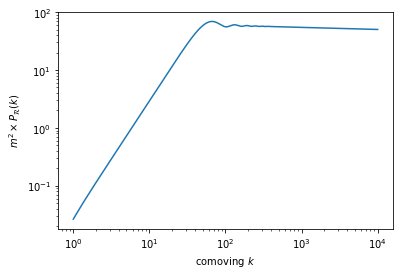

In [11]:
plt.loglog(ks, spectrum)
plt.xlabel('comoving $k$')
plt.ylabel('$m^2 \\times P_{\mathcal{R}}(k)$')
plt.show()

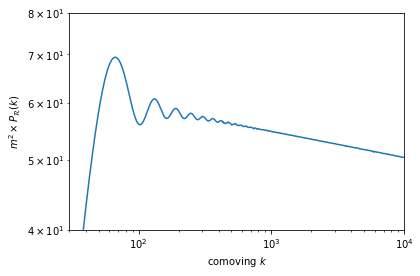

In [12]:
plt.loglog(ks, spectrum)
plt.xlabel('comoving $k$')
plt.ylabel('$m^2 \\times P_{\mathcal{R}}(k)$')
plt.xlim((3e1,1e4))
plt.ylim((40,80))
plt.show()

## A closed universe

All we have to do differently is:

1. solve the background equations again with $K=1$,

In [37]:
K = 1
N_i = -1.74
ok_i = 1.0
N = np.linspace(N_i,N_f,Nbg)
# Initial conditions
phi_i = np.sqrt(4.*(1./ok_i + K)*np.exp(-2.0*N_i)/m**2)
logok_i = np.log(ok_i)
y_i = np.array([logok_i, phi_i])
# Solve for the background until the end of inflation
endinfl.terminal = True
endinfl.direction = 1
bgsol = solve_ivp(bgeqs, (N_i,N_f), y_i, events=endinfl, t_eval=N, rtol=1e-8, atol=1e-10)

Number of e-folds of inflation now is

In [38]:
bgsol.t_events[0][0]-N_i

59.97999324176222

2. Update the arrays storing the cosmological background:

In [39]:
logok = bgsol.y[0]
phi = bgsol.y[1]
N = bgsol.t
dphi = np.array([-np.sqrt(6.0 + np.exp(Logok)*(6.0*K -
    2.0*np.exp(2.0*t)*V(Phi))) for Logok,Phi,t in zip(logok,phi,N) ])
dlogok = np.array([4.0 + np.exp(Logok)*(4.0*K - 2.0*np.exp(2.0*t)*V(Phi)) for Logok,Phi,t in zip(logok,phi,N) ])
dE_E = dlogok - 4. -2.*dV(phi)*np.exp(logok)*np.exp(2.*N)/dphi
E = 0.5*dphi**2

3. Update also the endpoint of integration for each mode:

In [40]:
# range of wavevectors
ks = np.concatenate((np.linspace(3,100,98), np.logspace(2,4,500)))
end = np.zeros_like(ks,dtype=int)
endindex = 0
for i in range(len(ks)):
    for j in range(endindex,Nbg):
        if np.exp(-0.5*logok[j])/ks[i] > 100:
            end[i] = j
            endindex = j
            break

4. Solve the MS equation for each $k$. The frequency and the damping term now have non-trivial wavevector-dependence, so we'll compute them on the fly for each mode.

In [41]:
closed_spectrum = np.zeros_like(ks,dtype=complex)
for i,k in enumerate(ks):
    # Bunch-Davies i.c.
    phi_0 = phi[0]
    dphi_0 = dphi[0]
    ddphi_0 = 0.5*dE_E[0]*dphi_0
    N_0 = N_i
    x0, dx0 = bdic(k, phi_0, dphi_0, ddphi_0, N_0)
    x01 = 1.0
    dx01 = 0.0
    x02 = 0.0
    dx02 = 1.0
    # wavenumber "squared"
    k2 = complex(k*(k+2.)-3*K)
    # Damping term
    g = 0.5*(K*np.exp(logok) + 3 - E + dE_E*k2/(E*K+k2))
    # frequency
    logw = 0.5*(logok + np.log(k2 - K - 2.*K*k2*dE_E/(E*K + k2)))
    # Linearly indep. solutions
    sol1 = pyoscode.solve(N,logw,g,N_i,N[end[i]],x01,dx01,logw=True)
    sol2 = pyoscode.solve(N,logw,g,N_i,N[end[i]],x02,dx02,logw=True)
    rk1 = sol1["sol"][-1]
    rk2 = sol2["sol"][-1]
    closed_spectrum[i] = pps(k, rk1, rk2, x01, dx01, x02, dx02, x0, dx0)

Plot the resulting spectrum:

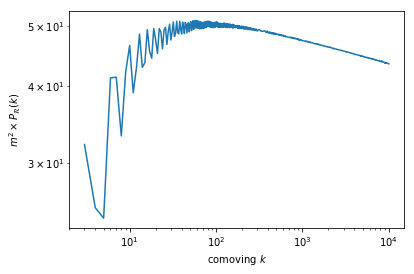

In [42]:
plt.loglog(ks, closed_spectrum)
plt.xlabel('comoving $k$')
plt.ylabel('$m^2 \\times P_{\mathcal{R}}(k)$')
plt.show()

Note that in the above spectrum, the jaggedness is due to the fact that the values $k$ takes are quantised (integers only).